# INTENT CHARACTERIZATION

TO DO :  
    * track pipeline w/ airflow  
* **workload**: 
    * 4 hours

In [4]:
import pandas as pd
import time
import numpy as np

# visualization
from matplotlib import pyplot as plt

# preprocessing
import spacy
from spacy import tokenizer
from spacy.lang.en import English

# exploration
import re

In [5]:
proj_path = "/Users/steeve_laquitaine/desktop/CodeHub/intent/intent/"
train_data_path = proj_path + "data/01_raw/banking77/train.csv"
test_data_path = proj_path + "data/01_raw/banking77/test.csv"

In [6]:
train_data  = pd.read_csv(train_data_path)

In [7]:
# preview
train_data.head(5)

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [8]:
print('{} unique labels'.format(train_data.category.nunique()))
print(train_data.category.unique())

77 unique labels
['card_arrival' 'card_linking' 'exchange_rate'
 'card_payment_wrong_exchange_rate' 'extra_charge_on_statement'
 'pending_cash_withdrawal' 'fiat_currency_support'
 'card_delivery_estimate' 'automatic_top_up' 'card_not_working'
 'exchange_via_app' 'lost_or_stolen_card' 'age_limit' 'pin_blocked'
 'contactless_not_working' 'top_up_by_bank_transfer_charge'
 'pending_top_up' 'cancel_transfer' 'top_up_limits'
 'wrong_amount_of_cash_received' 'card_payment_fee_charged'
 'transfer_not_received_by_recipient' 'supported_cards_and_currencies'
 'getting_virtual_card' 'card_acceptance' 'top_up_reverted'
 'balance_not_updated_after_cheque_or_cash_deposit'
 'card_payment_not_recognised' 'edit_personal_details'
 'why_verify_identity' 'unable_to_verify_identity' 'get_physical_card'
 'visa_or_mastercard' 'topping_up_by_card' 'disposable_card_limits'
 'compromised_card' 'atm_support' 'direct_debit_payment_not_recognised'
 'passcode_forgotten' 'declined_cash_withdrawal' 'pending_card_payme

In [65]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

Took 0.23 secs


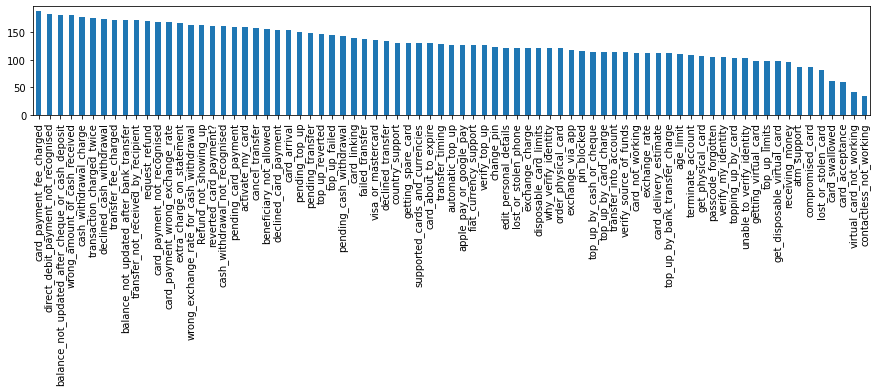

In [82]:
tic = time.time()
train_data.category.value_counts().plot(
    kind='bar', 
    # y=train_data.category.value_counts().index, 
    # x=train_data.category.value_counts().values, 
    figsize=(15,2)
    );
print('Took {} secs'.format(np.round(time.time()-tic,2)))    

In [41]:
# list labels sorted by occurrence frequency
intents_by_popularity = train_data.category.value_counts().index.tolist()
intents_by_popularity[:10]

['card_payment_fee_charged',
 'direct_debit_payment_not_recognised',
 'balance_not_updated_after_cheque_or_cash_deposit',
 'wrong_amount_of_cash_received',
 'cash_withdrawal_charge',
 'transaction_charged_twice',
 'declined_cash_withdrawal',
 'transfer_fee_charged',
 'balance_not_updated_after_bank_transfer',
 'transfer_not_received_by_recipient']

In [40]:
# show top intent requests
top_label_data = train_data.text.loc[train_data.category==intents_by_popularity[0]]
top_label_data.tolist()[:10]

['There was a fee charged when I paid with my card.',
 'I received a fee I should not have.',
 'Why am I being a charged for using my card?',
 'Tell me why there is a fee for a card payment.',
 "I don't understand why I'm being charged for using my card.",
 'I paid with my card so so why was I charged a transaction fee?',
 "I shouldn't have been charged but I see a fee, why?",
 'i made a payment with my card and was charged a fee, why would you do that',
 'A fee came along with me paying with card',
 'I had to pay a fee when buying items with my card.']

# Explore vocabulary

In [12]:
# convert data Series to one data String
data_string = " ".join(top_label_data.to_list())

In [13]:
# tokenize text
def tokenize_txt(data_string, tokenizer, English):
    tokenize = tokenizer.Tokenizer(English().vocab)
    tokens = tokenize(data_string)
    print("{} tokens".format(len(tokens)))
    return tokens
tokens = tokenize_txt(data_string, tokenizer, English)        

2619 tokens


In [19]:
print(list(tokens[:100]))

[There, was, a, fee, charged, when, I, paid, with, my, card., I, received, a, fee, I, should, not, have., Why, am, I, being, a, charged, for, using, my, card?, Tell, me, why, there, is, a, fee, for, a, card, payment., I, don't, understand, why, I'm, being, charged, for, using, my, card., I, paid, with, my, card, so, so, why, was, I, charged, a, transaction, fee?, I, shouldn't, have, been, charged, but, I, see, a, fee,, why?, i, made, a, payment, with, my, card, and, was, charged, a, fee,, why, would, you, do, that, A, fee, came, along, with, me, paying]


# Characterize intent's requests

* Requests dimensions
  * clause types
    * interrogative (1)
        * closed
        * open
    * declarative
    * imperative (2)
        * wishes
        * orders
    * exclamative

In [90]:
top_intent_text = train_data.text[train_data.category.eq(top_intent)].tolist()
top_intent_text[:10]

['There was a fee charged when I paid with my card.',
 'I received a fee I should not have.',
 'Why am I being a charged for using my card?',
 'Tell me why there is a fee for a card payment.',
 "I don't understand why I'm being charged for using my card.",
 'I paid with my card so so why was I charged a transaction fee?',
 "I shouldn't have been charged but I see a fee, why?",
 'i made a payment with my card and was charged a fee, why would you do that',
 'A fee came along with me paying with card',
 'I had to pay a fee when buying items with my card.']

### Sentence types

In [291]:
# either ? or ! or .
SENT_TYPE_PATTN = re.compile(r"[\?\!\.]")

def classify_sentence_type(sentences):
    """
    Classify sentence type
    """
    sent_type = []
    for sent in sentences:
        out = SENT_TYPE_PATTN.findall(sent)
        sent_type.append(['ask' if ix=='?' else 'wish-or-excl' if ix=='!' else 'state' for ix in out])        
    return sent_type

sentence_type = classify_sentence_type(train_data.text.tolist())

In [293]:
train_data_feat = train_data.copy()
train_data_feat["sentence_type"] = sentence_type
train_data_feat.head(20)

,text,category,sentence_type
0,I am still waiting on my card?,card_arrival,[ask]
1,What can I do if my card still hasn't arrived ...,card_arrival,[ask]
2,I have been waiting over a week. Is the card s...,card_arrival,"[state, ask]"
3,Can I track my card while it is in the process...,card_arrival,[ask]
4,"How do I know if I will get my card, or if it ...",card_arrival,[ask]
5,When did you send me my new card?,card_arrival,[ask]
6,Do you have info about the card on delivery?,card_arrival,[ask]
7,What do I do if I still have not received my n...,card_arrival,[ask]
8,Does the package with my card have tracking?,card_arrival,[ask]
9,I ordered my card but it still isn't here,card_arrival,[]



# References

(1) https://allthingslinguistic.com/post/160783915317/being-a-declarative-or-interrogative-or  
(2) https://oxford.universitypressscholarship.com/view/10.1093/acprof:oso/9780199283613.001.0001/acprof-9780199283613-chapter-6  